In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


Adding column Rank: each Address has a rank. higher the rank means higher the price

In [3]:
grouped_df = df.groupby("Address").agg({'Price': 'median'}).sort_values(by="Price").reset_index()
grouped_df["Rank"] = grouped_df['Price'].rank(ascending=True).astype('int')
df = df.merge(grouped_df[['Address', 'Rank']], on='Address', how='inner')

sanitization1: find columns that have missing data

In [6]:
columns_des = [df[[column]].isnull().any() for column in df.columns]
missing_data_columns = []
for c in columns_des:
    if c[0]:
        missing_data_columns.append(c)
        
missing_data_columns

/tmp/ipykernel_39076/146939093.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if c[0]:


[]

sanitization2: deleting invalid,large Area data from dataset

In [7]:
indices_to_drop = []
for i in range(len(df)):
    if len(df["Area"][i]) > 3:
        indices_to_drop.append(i)
df = df.drop(indices_to_drop)

In [8]:
df = df.replace({True: 1, False:0})
df["Area"] = df["Area"].astype(int)

/tmp/ipykernel_39076/2643601247.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False:0})


drop useless columns

In [9]:
df = df.drop(columns=["Address", "Price(USD)"], axis=1)

sanitization3: removing outliers in Area 

In [10]:
Q3 = df["Area"].quantile(0.75)
Q1 = df["Area"].quantile(0.25)
IQR = Q3 - Q1
upper_whisker = Q3 + 1.5 * IQR
lower_whisker = Q1 - 1.5 * IQR
lower_whisker = lower_whisker if lower_whisker > 0 else 0 
mask = (df["Area"] <= upper_whisker) & (df["Area"] >= lower_whisker)
df = df[mask]

normalising data frame

In [11]:
df = (df - df.mean()) / df.std()

splitting dataset into 80% train and 20% test

In [12]:
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
test = df[~mask]
features = ["Area", "Room", "Parking", "Warehouse", "Elevator", "Rank"]
x_train = train[features]
y_train = train[["Price"]]
x_test = test[features]
y_test = test[["Price"]]

visualizing current features

Text(0, 0.5, 'price')

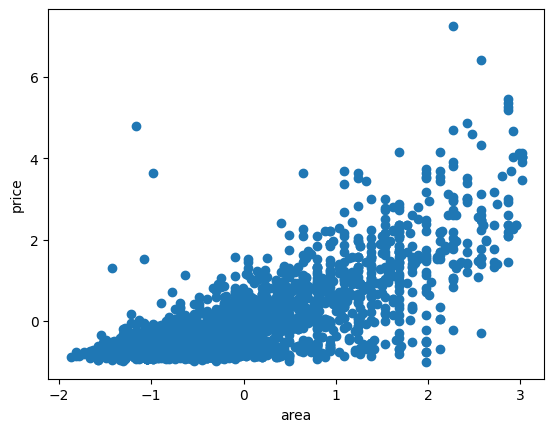

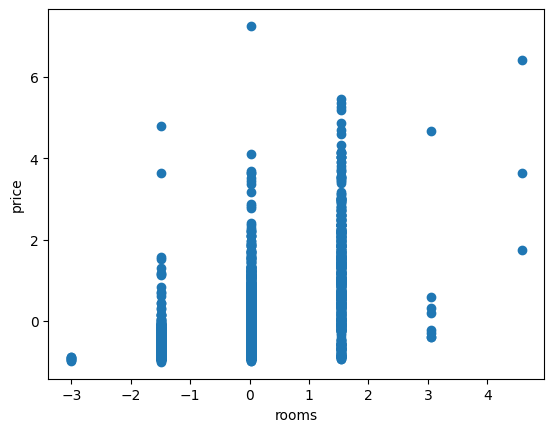

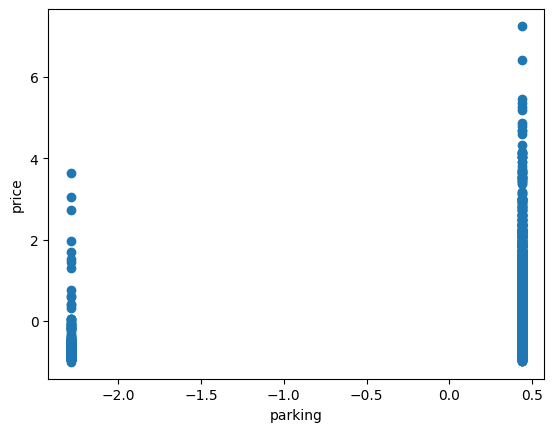

In [13]:
plt.scatter(x_train["Area"], y_train["Price"])
plt.xlabel("area")
plt.ylabel("price")
plt.figure()
plt.scatter(x_train["Room"], y_train["Price"])
plt.xlabel("rooms")
plt.ylabel("price")
plt.figure()
plt.scatter(x_train["Parking"], y_train["Price"])
plt.xlabel("parking")
plt.ylabel("price")

In [14]:
linear_regression = linear_model.LinearRegression()

linear regression (parameters: area)

/home/msgh/Documents/books/practical_deeplearning/pythonProject/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


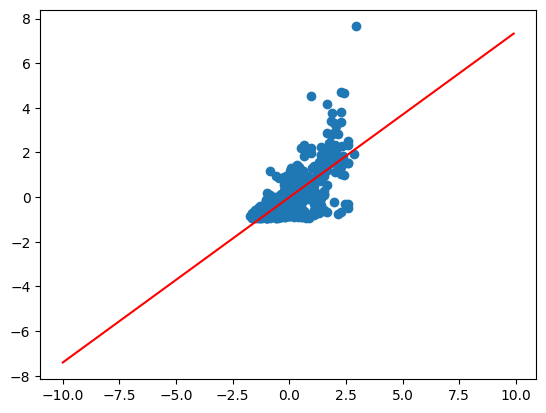

In [15]:
linear_regression.fit(np.array(x_train[["Area"]]), np.array(y_train))
y_test_ = linear_regression.predict(x_test[["Area"]])
r2_score(y_test, y_test_)
x_axes = np.arange(-10,10,0.1)
plt.plot(x_axes, linear_regression.coef_[0] * x_axes + linear_regression.intercept_[0], 'r-')
plt.scatter(x_test["Area"], y_test)

polynomial regression (parameters: area)

In [16]:
def poly_reg(features, features_size:int):
    poly = PolynomialFeatures(features_size)
    linear_regression.fit(poly.fit_transform(x_train[features]), y_train)
    y_test_ = linear_regression.predict(poly.fit_transform(x_test[features]))
    if features_size == 1:
        y = linear_regression.coef_[0][1] * x_axes + linear_regression.intercept_[0] 
    elif features_size == 2:
        y = linear_regression.coef_[0][1] * x_axes + linear_regression.coef_[0][2] * (x_axes ** 2) + linear_regression.intercept_[0]
    elif features_size == 3:
        y = linear_regression.coef_[0][1] * x_axes + linear_regression.coef_[0][2] * (x_axes ** 2) + linear_regression.coef_[0][3] * (x_axes ** 3) + linear_regression.intercept_[0]
    plt.plot(x_axes, y, "r-")
    plt.scatter(x_test["Area"], y_test)
    print("r2 score: ", r2_score(y_test, y_test_))

r2 score:  0.48716689035203364


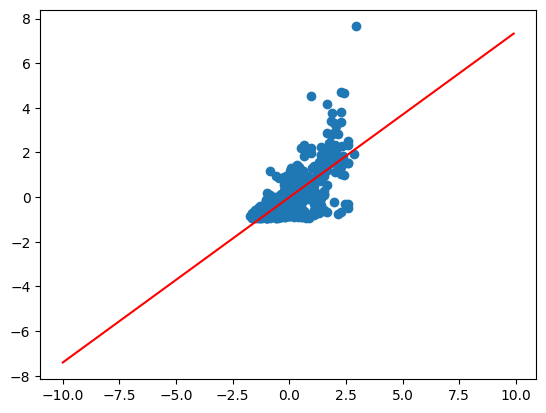

In [17]:
features = ["Area"]
poly_reg(features, 1)

linear regression (parameters: area, rank)

In [18]:
linear_regression.fit(x_train[["Area", "Rank"]], y_train)
y_test_ = linear_regression.predict(x_test[["Area", "Rank"]])
r2_score(y_test, y_test_)

0.7257455959114842

polynomial regression (parameters: area, rank)

r2 score:  0.8179959468238874


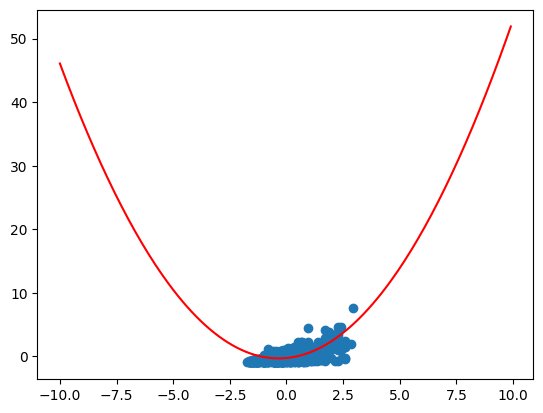

In [19]:
features = ["Area", "Rank"]
poly_reg(features, 2)